<img src="https://github.com/pmservice/ai-openscale-tutorials/raw/master/notebooks/images/banner.png" align="left" alt="banner">

# Monitor AWS Sagemaker Model With Watson OpenScale

### Contents
- [Set up Project Token and API Key](#tokens)
- [Introduction](#intro)
- [Setup](#setup)
- [Fetch Model and Deployments](#model)
- [Configure OpenScale](#openscale)
- [Create Service Provider and Subscription](#subscription)
- [Quality monitor](#quality)
- [Fairness monitor](#fairness)
- [Explanations](#explain)

### Set up Project Token and API Key  <a name="tokens"></a>
Before executing this notebook, you need to insert a project token and an IBM Cloud API key:<br>

#### Provide the project access token
1. When you imported the project from the Gallery, the first cell of this notebook should contain the project access token. 

2. If this notebook does not contain a first cell with a project access token, then to generate the token, click **More > Insert project token** on the menu bar.<br>

![ws-project.mov](https://media.giphy.com/media/jSVxX2spqwWF9unYrs/giphy.gif)



#### Provide your IBM Cloud API key
1. Generate an IBM Cloud API key on the [API Keys page in the IBM Cloud console](https://cloud.ibm.com/iam/apikeys).
2. Click **Create an IBM Cloud API key**. Provide a key name, and click **Create**, then copy the created key and paste it below. As a best practice, download the API key in addition to copying the key. 


In [2]:
ibmcloud_api_key = ''

You can then step through the notebook execution cell by cell, by selecting Shift-Enter. Or you can execute the entire notebook by selecting **Cell -> Run All** from the menu.<br>

## Introduction<a name="intro"></a>
You trained Demand Response Prediction Model on AWS Sagemaker and deployed it to generate an endpoint. In this notebook, you will programmatically set up and configure OpenScale, create a data mart for the model with Watson OpenScale and configure OpenScale to monitor that deployment, and inject records and measurements for viewing in the OpenScale insights dashboard. The notebook by default uses the postgres internal db.


## Setup <a name="setup"></a>

In the cells below, you install/import the python libraries that you will use throughout the notebook.`ibm_watson_openscale` is a python library that allows to work with [Watson OpenScale services](http://ai-openscale-python-client.mybluemix.net/) on IBM Cloud Pak for Data. 
 

In [3]:
import os
import datetime
import base64
import json
import requests
import time 
import boto3
import pandas as pd

import ibm_db, ibm_db_dbi as dbi

If you are not using latest version of the watson openscale library, use the below cells to upgrade.

### User Inputs


#### 1. WOS Credentials
Below cell uses ibm cloud api key to authenticate to Watson Openscale.

In [4]:
from ibm_cloud_sdk_core.authenticators import IAMAuthenticator,BearerTokenAuthenticator

from ibm_watson_openscale import *
from ibm_watson_openscale.supporting_classes.enums import *
from ibm_watson_openscale.supporting_classes import *


authenticator = IAMAuthenticator(apikey=ibmcloud_api_key)
wos_client = APIClient(authenticator=authenticator)


This tutorial can use Databases for PostgreSQL, Db2 Warehouse, or a free internal verison of PostgreSQL to create a datamart for OpenScale.

If you do not have a paid Cloud account or would prefer not to provision this paid service, you may use the free internal PostgreSQL service with OpenScale. Do not update the cell below.

If you previously configured OpenScale to use the free internal version of PostgreSQL, you can switch to a new datamart using a paid database service. If you would like to delete the internal PostgreSQL configuration and create a new one using service credentials supplied in the cell above, set the KEEP_MY_INTERNAL_POSTGRES variable below to False below. In this case, the notebook will remove your existing internal PostgreSQL datamart and create a new one with the supplied credentials. NO DATA MIGRATION WILL OCCUR.

In [5]:
KEEP_MY_INTERNAL_POSTGRES = True

In [6]:
DB_CREDENTIALS = None
SCHEMA_NAME = None

#### 2. IBM Cloud Object Storage credentials
Refer to IBM Cloud [documentation](https://cloud.ibm.com/docs/account?topic=account-service_credentials&interface=ui) to generate Cloud object storage credentials.
These credentials are used to store training data for OpenScale reference
- `bucket_name` must be a unique and DNS-safe string. Because bucket names are unique across the entire system, these values need to be changed if this example is run multiple times. Note that names are reserved for 10 - 15 minutes after deletion.
- `ibm_api_key_id` is the value found in the Service Credential as apikey.
- `ibm_service_instance_id` is the value found in the Service Credential as resource_instance_id.
- `endpoint_url` is a service endpoint URL, inclusive of the https:// protocol. This value is not the endpoints value that is found in the Service Credential. For more information about endpoints, see Endpoints and storage locations.

In [7]:

IAM_URL=""
COS_RESOURCE_CRN=""
COS_API_KEY_ID = ""
COS_ENDPOINT = ""



In [8]:
demandresponseinput = project.get_file("demandresponseinput.csv")
demandresponseinput.seek(0)
df_raw = pd.read_csv(demandresponseinput)
df_raw.to_csv("demandresponseinput.csv",index=False)

In [9]:
BUCKET_NAME = "ws-openscale" 
training_data_file_name="demandresponseinput.csv"

In [10]:
import ibm_boto3
from ibm_botocore.client import Config, ClientError

cos_client = ibm_boto3.resource("s3",
    ibm_api_key_id=COS_API_KEY_ID,
    ibm_service_instance_id=COS_RESOURCE_CRN,
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version="oauth"),
    endpoint_url=COS_ENDPOINT
)

In [11]:
with open(training_data_file_name, "rb") as file_data:
    cos_client.Object(BUCKET_NAME, training_data_file_name).upload_fileobj(
        Fileobj=file_data
    )

#### 3. AWS Sagemaker Credentials
Provide AWS credentials in the below cell. These credentials are used to fetch the model and its deployment located on AWS Sagemaker. 

In [12]:
SAGEMAKER_ENGINE_CREDENTIALS = {
                   'access_key_id': '', 
                   'secret_access_key': '', 
                   'region': ''}

Enter the model name thats deployed on AWS Sagemaker below.

In [13]:
sagemaker_deployment=""

Apart from these inputs, the following details can also be updated while running the notebook.

1. Columns used in the model and the target column details in [Create Subscription](#subscription) section.
2. Favourable class, unfavourable class, features to monitor bias for, majority and minority columns for bias in [Fairness monitor](#fairness) section .

## Configure OpenScale <a name="openscale"></a>

Once you have all the user inputs, now you can configure OpenScale. These are the set of steps involved in configuring OpenScale.
1. Create an api client to start working with client library using WOS credentials .
2. If a data mart doesn't exist Create or Update a data mart using Database credentials on the api client.
3. Create a binding between the api client and the AWS Sagemaker instances.
4. List all the existing bindings.
5. Create and manage subscriptions of machine learning models deployments.

In [14]:
wos_client.data_marts.show()

WOS Data Mart,Data Mart - Vikram Bhat,True,active,2023-02-08 10:09:06.308000+00:00,b78d9fcd-74b7-4b17-a6bf-1983299bafc5


### Create/Set up datamart

Watson OpenScale uses a database to store payload logs and calculated metrics. The datamart will be created with the database credentials provided above unless there is an existing datamart. If there is an existing data mart, it will be used throughout this notebook.

In [15]:
data_marts = wos_client.data_marts.list().result.data_marts
if len(data_marts) == 0:
    if DB_CREDENTIALS is not None:
        if SCHEMA_NAME is None: 
            print("Please specify the SCHEMA_NAME and rerun the cell")

        print('Setting up external datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart created by Industry Accelerator",
                database_configuration=DatabaseConfigurationRequest(
                  database_type=DatabaseType.POSTGRESQL,
                    credentials=PrimaryStorageCredentialsLong(
                        hostname=DB_CREDENTIALS['hostname'],
                        username=DB_CREDENTIALS['username'],
                        password=DB_CREDENTIALS['password'],
                        db=DB_CREDENTIALS['database'],
                        port=DB_CREDENTIALS['port'],
                        ssl=True,
                        sslmode=DB_CREDENTIALS['sslmode'],
                        certificate_base64=DB_CREDENTIALS['certificate_base64']
                    ),
                    location=LocationSchemaName(
                        schema_name= SCHEMA_NAME
                    )
                )
             ).result
    else:
        print('Setting up internal datamart')
        added_data_mart_result = wos_client.data_marts.add(
                background_mode=False,
                name="WOS Data Mart",
                description="Data Mart - Vikram Bhat", 
                internal_database = True).result
        
    data_mart_id = added_data_mart_result.metadata.id
    
else:
    data_mart_id=data_marts[0].metadata.id
    print('Using existing datamart {}'.format(data_mart_id))
    

Using existing datamart b78d9fcd-74b7-4b17-a6bf-1983299bafc5


### Create Service Provider and Subscription <a name="subscription"></a>

Once the data mart is setup, you can now create and manage service providers of  models deployments. Service Providers binds Watson OpenScale to the Watson Machine Learning instance to capture payload data into and out of the model. It involves following steps.
1. List all the service providers for the WOS client.
2. Delete if a service provider already exists for the model.
3. Create a new service provider.

In [16]:
SERVICE_PROVIDER_NAME = "Demand Response Sagemaker-Openscale"
SERVICE_PROVIDER_DESCRIPTION = "Added by VB Sagemaker Integration"

In [17]:
service_providers = wos_client.service_providers.list().result.service_providers
for service_provider in service_providers:
    service_instance_name = service_provider.entity.name
    if service_instance_name == SERVICE_PROVIDER_NAME:
        service_provider_id = service_provider.metadata.id
        wos_client.service_providers.delete(service_provider_id)
        print("Deleted existing service_provider for AWS Sagemaker instance: {}".format(service_provider_id))

Deleted existing service_provider for AWS Sagemaker instance: 4011b5c4-0ca5-48fa-9a4e-51337bb59bcd


In [18]:
added_service_provider_result=wos_client.service_providers.add(
        name=SERVICE_PROVIDER_NAME,
        description="AWS Service Provider",
        service_type=ServiceTypes.AMAZON_SAGEMAKER,
        operational_space_id = "production", 
        credentials=SageMakerCredentials(
            access_key_id=SAGEMAKER_ENGINE_CREDENTIALS['access_key_id'],
            secret_access_key=SAGEMAKER_ENGINE_CREDENTIALS['secret_access_key'],
            region=SAGEMAKER_ENGINE_CREDENTIALS['region']
        ),
        background_mode=False
    ).result



service_provider_id = added_service_provider_result.metadata.id
print("Service Provider id ", service_provider_id)




 Waiting for end of adding service provider fa585f6d-491b-41f3-b800-067c210051b1 




active

-----------------------------------------------
 Successfully finished adding service provider 
-----------------------------------------------


Service Provider id  fa585f6d-491b-41f3-b800-067c210051b1


In [19]:
wos_client.service_providers.show()

None,active,Demand Response Sagemaker-Openscale,amazon_sagemaker,2023-02-23 14:35:41.923000+00:00,fa585f6d-491b-41f3-b800-067c210051b1
None,active,Demand Response Sagemaker,amazon_sagemaker,2023-02-09 12:31:33.185000+00:00,6f5aac61-a828-4f31-9288-86f8b3797a4b


### Fetch AWS Sagemaker Model and Deployment
Below cell fetches the model from AWS Sagemaker using above service provider id and stores its deployment id. 

In [20]:
asset_deployment_details = wos_client.service_providers.list_assets(data_mart_id=data_mart_id, service_provider_id=service_provider_id).result

for i in asset_deployment_details['resources']:
    if sagemaker_deployment in i['metadata']['url']:
        deployment_id=i['metadata']['guid']
    
for model_asset_details in asset_deployment_details['resources']:
    if model_asset_details['metadata']['guid']==deployment_id:
        break




Below cell uses model details to fetch Sagemaker scoring endpoint details of the model and creates an openscale deployment request with the endpoint

In [21]:
aws_asset = Asset(
        asset_id=model_asset_details['entity']['asset']['asset_id'],
        name=model_asset_details['entity']['asset']['name'],
        url=model_asset_details['entity']['scoring_endpoint']['url'],
        asset_type=model_asset_details['entity']['asset']['asset_type'] if 'asset_type' in model_asset_details['entity']['asset'] else 'model',
        problem_type=ProblemType.BINARY_CLASSIFICATION,
        input_data_type=InputDataType.STRUCTURED,
    )

from ibm_watson_openscale.base_classes.watson_open_scale_v2 import ScoringEndpointRequest
deployment_scoring_endpoint = model_asset_details['entity']['scoring_endpoint']
scoring_endpoint = ScoringEndpointRequest(url = model_asset_details['entity']['scoring_endpoint']['url'] )

deployment = AssetDeploymentRequest(
        deployment_id=model_asset_details['metadata']['guid'],
        url=model_asset_details['metadata']['url'],
        name=model_asset_details['entity']['name'],
        deployment_type=model_asset_details['entity']['type'],
        scoring_endpoint =  scoring_endpoint
    )

### Subscriptions

This code creates the model subscription in OpenScale using the Python client API. 
In order to create a new subscription, you will need to provide following details
1. `Model details` including Model id, type, input_data_type(STRUCTURED or UNSTRUCTURED), Problem type(BINARY_CLASSIFICATION, REGRESSION, MULTI_CLASSIFICATION)
2. `Model deployment details` including deployment name, id, type, url.
3. `Training Data Reference`: training data specified in the user inputs cell
4. `Asset Properties`: <br>
    a. label_column: Prediction column name.<br>
    b. feature_fields: Columns used in the training data set.<br>
    c. categorical_fields: set of Catgorical columns in the training data set.<br>


When a subscription is successfully created, you should be able to see it in the path `{HOST}/aiopenscale/insights`.

In [22]:
model_asset_details

{'metadata': {'guid': '1a6a661604f71b3be0002d877ee0c114',
  'url': 'Openscale-SKLearn-demandresponse-ep23-09-35-26',
  'created_at': '2023-02-23T09:35:26.460Z',
  'modified_at': '2023-02-23T09:37:31.407Z'},
 'entity': {'name': 'Openscale-SKLearn-demandresponse-ep23-09-35-26',
  'deployment_rn': 'arn:aws:sagemaker:us-east-1:849589503910:endpoint/openscale-sklearn-demandresponse-ep23-09-35-26',
  'type': 'online',
  'scoring_endpoint': {'url': 'Openscale-SKLearn-demandresponse-ep23-09-35-26'},
  'asset': {'asset_id': '434eec0301374ab2da9e938958d84c91',
   'asset_rn': 'arn:aws:sagemaker:us-east-1:849589503910:model/sklearn-demandresponse23-09-35-24',
   'name': 'SKLearn-demandresponse23-09-35-24',
   'asset_type': 'model',
   'created_at': '2023-02-23T09:35:25.499Z'},
  'asset_properties': {'asset_revision': '1677145051407'}}}

In [23]:
training_data_reference = TrainingDataReference(type='cos',
                                              location=COSTrainingDataReferenceLocation(bucket = BUCKET_NAME,
                                                                                        file_name = training_data_file_name),
                                              connection=COSTrainingDataReferenceConnection(
                                                                        resource_instance_id= COS_RESOURCE_CRN,
                                                                        url= COS_ENDPOINT,
                                                                        api_key= COS_API_KEY_ID,
                                                                        iam_url=IAM_URL)
                                               )

In [24]:
feature_columns = ["CUSTOMER_ID", "CSTFNM", "CSTLNM", "CSTPH1", "CSTML", "AGE", "CITY","MARITAL_STATUS", "GENDER", "EDUCATION", "EMPLOYMENT", "TENURE", "SEGMENT","HOME_SIZE", "ENERGY_USAGE_PER_MONTH", "ENERGY_EFFICIENCY","IS_REGISTERED_FOR_ALERTS", "OWNS_HOME", "COMPLAINTS", "EST_INCOME", "CLTV","HAS_THERMOSTAT", "HAS_HOME_AUTOMATION", "PHOTOVOLTAIC_ZONING", "WIND_ZONING","SMART_METER_COMMENTS", "IS_CAR_OWNER", "HAS_EV", "HAS_PHOTOVOLTAIC", "HAS_WIND","EBILL", "IN_WARRANTY", "STD_YRLY_USAGE", "MISSED_PAYMENT","YEARLY_USAGE_PREDICTED"]

categorical_columns = ["CITY","MARITAL_STATUS", "GENDER", "EDUCATION", "EMPLOYMENT", "SEGMENT","OWNS_HOME", "COMPLAINTS", "HAS_THERMOSTAT", "HAS_HOME_AUTOMATION", "PHOTOVOLTAIC_ZONING", "WIND_ZONING","SMART_METER_COMMENTS", "IS_CAR_OWNER", "HAS_EV", "HAS_PHOTOVOLTAIC", "HAS_WIND","EBILL", "IN_WARRANTY", "MISSED_PAYMENT"]
asset_properties = AssetPropertiesRequest(
        label_column="DEMAND_RESPONSE",
        probability_fields=["probability"],
        prediction_field="prediction",
        training_data_reference=training_data_reference,
        training_data_schema=None,
        input_data_schema=None,
        output_data_schema=None,
        feature_fields=feature_columns,
        categorical_fields=categorical_columns
    )

In [25]:
subscription_details = wos_client.subscriptions.add(
        data_mart_id=data_mart_id,
        service_provider_id=service_provider_id,
        asset=aws_asset,
        deployment=deployment,
        asset_properties=asset_properties,
        background_mode=False
).result
subscription_id = subscription_details.metadata.id
subscription_id




 Waiting for end of adding subscription 0535a4b5-d4e3-47a0-8c6e-3e589a487a74 




active

-------------------------------------------
 Successfully finished adding subscription 
-------------------------------------------




'0535a4b5-d4e3-47a0-8c6e-3e589a487a74'

In [26]:
wos_client.subscriptions.show()

434eec0301374ab2da9e938958d84c91,SKLearn-demandresponse23-09-35-24,b78d9fcd-74b7-4b17-a6bf-1983299bafc5,1a6a661604f71b3be0002d877ee0c114,Openscale-SKLearn-demandresponse-ep23-09-35-26,fa585f6d-491b-41f3-b800-067c210051b1,active,2023-02-23 14:35:53.196000+00:00,0535a4b5-d4e3-47a0-8c6e-3e589a487a74
7ba4310b9fc7c1b1d3d9342087c50e0e,SKLearn-demandresponse09-12-23-15,b78d9fcd-74b7-4b17-a6bf-1983299bafc5,6f1c9b4764db53df9e74b156f6bf01da,Openscale-SKLearn-demandresponse-ep09-12-23-20,6f5aac61-a828-4f31-9288-86f8b3797a4b,active,2023-02-09 12:31:44.712000+00:00,0d11f26f-5404-4316-af40-75589f218b0f


In [27]:
subscription_details=wos_client.subscriptions.get(subscription_id).result.to_dict()


In [28]:

time.sleep(5)
payload_data_set_id = None
payload_data_set_id = wos_client.data_sets.list(type=DataSetTypes.PAYLOAD_LOGGING, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result.data_sets[0].metadata.id
if payload_data_set_id is None:
    print("Payload data set not found. Please check subscription status.")
else:
    print("Payload data set id: ", payload_data_set_id)

Payload data set id:  e9797c84-efe9-49f2-9eb8-cab4a3e4df3e


### Score the model to configure monitors
Now that the Sagemaker service has been bound and the subscription has been created, we need to send a request to the model endpoint before we configure OpenScale monitors. This allows OpenScale to create a payload log in the datamart with the correct schema, so it can capture data coming into and out of the model. First, the code gets the model deployment's endpoint URL, and then sends sample records for predictions.

In [29]:
os_payload={"Input":df_raw[feature_columns].head(20).dropna().values.tolist(),"Headers":feature_columns}
payload=json.dumps(os_payload)

endpoint_name = subscription_details['entity']['deployment']['name']

runtime = boto3.client('sagemaker-runtime',
                       region_name=SAGEMAKER_ENGINE_CREDENTIALS['region'],
                       aws_access_key_id=SAGEMAKER_ENGINE_CREDENTIALS['access_key_id'],
                       aws_secret_access_key=SAGEMAKER_ENGINE_CREDENTIALS['secret_access_key'])


response = runtime.invoke_endpoint(EndpointName=endpoint_name, ContentType="application/json", Body=payload)

result = json.loads(response['Body'].read().decode())

print(json.dumps(result, indent=2))

{
  "predictions": [
    {
      "prediction": 0,
      "probability": [
        0.8402606369822012,
        0.15973936301779892
      ]
    },
    {
      "prediction": 0,
      "probability": [
        0.9309369360827958,
        0.06906306391720402
      ]
    },
    {
      "prediction": 1,
      "probability": [
        0.15986462726641704,
        0.840135372733583
      ]
    },
    {
      "prediction": 0,
      "probability": [
        0.8539428717357177,
        0.14605712826428233
      ]
    },
    {
      "prediction": 0,
      "probability": [
        0.9222179179228759,
        0.0777820820771242
      ]
    },
    {
      "prediction": 1,
      "probability": [
        0.23679218633495586,
        0.7632078136650441
      ]
    },
    {
      "prediction": 0,
      "probability": [
        0.9643727384933577,
        0.03562726150664233
      ]
    },
    {
      "prediction": 0,
      "probability": [
        0.882137779559125,
        0.1178622204408751
      ]
    },

In [30]:

request_data = {'fields': feature_columns, 
                'values': json.loads(payload)['Input']}

response_data = result

By scoring against the deployment will store the data as payload records, which is called payload logging. It can be verified if payload logging has loaded records into payload table, If the records are not loaded store_records() method can be used as below to store the records manually.

In [31]:
import uuid
from ibm_watson_openscale.supporting_classes.payload_record import PayloadRecord

print("Performing explicit payload logging.....")
wos_client.data_sets.store_records(data_set_id=payload_data_set_id, background_mode=False,request_body=[PayloadRecord(
           scoring_id=str(uuid.uuid4()),
           request=request_data,
           response=response_data,
           response_time=460
)])
time.sleep(5)
pl_records_count = wos_client.data_sets.get_records_count(payload_data_set_id)
print("Number of records in the payload logging table: {}".format(pl_records_count))

Performing explicit payload logging.....



 Waiting for end of storing records with request id: 3a444be9-366f-4c0f-b0f2-ba51fcbebbc9 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------


Number of records in the payload logging table: 18


In [32]:
wos_client.data_sets.show_records(data_set_id=payload_data_set_id)

59972.4,None,Associate degree,e6ab7616-876c-44b5-9172-112c7cd4d4b4-1,True,False,True,2023-02-23T14:36:04.158Z,352.0,False,0.8402606369822012,male,Mountain View,1980,1,47870,56049,Leonor,0,True,Employed full-time,Green Advocate,5080,True,781-757-3537,44,True,S,False,True,Leonor.Cummerata@nola.biz,True,Negative,1a6a661604f71b3be0002d877ee0c114,0.39,13,False,Cummerata,False,True,False,"[0.8402606369822012, 0.15973936301779892]"
47732.8,None,High school graduate,e6ab7616-876c-44b5-9172-112c7cd4d4b4-10,False,False,True,2023-02-23T14:36:04.158Z,159.0,False,0.8581521682523892,female,Sunnyvale,1100,12,14578,44197,Mandy,1,True,Employed part-time,Budget Payment Plan Members,2460,True,847-713-6642,64,False,U,False,True,Mandy.Reichert@madyson.biz,False,Positive,1a6a661604f71b3be0002d877ee0c114,0.447,7,False,Reichert,True,True,True,"[0.1418478317476109, 0.8581521682523892]"
41545.2,None,Some high school,e6ab7616-876c-44b5-9172-112c7cd4d4b4-11,False,False,False,2023-02-23T14:36:04.158Z,188.0,False,0.8958480890733549,male,Sunnyvale,1790,13,48238,44197,Alexandro,0,True,Retired,Budget Payment Plan Members,5260,True,802-761-2991,17,False,U,False,True,Alexandro.Willms@geo.name,False,Neutral,1a6a661604f71b3be0002d877ee0c114,0.34,41,True,Willms,False,True,True,"[0.8958480890733549, 0.104151910926645]"
48616.7,None,Some college,e6ab7616-876c-44b5-9172-112c7cd4d4b4-12,False,False,True,2023-02-23T14:36:04.158Z,111.0,True,0.9232474643303117,male,Mountain View,2960,14,48238,44197,Emiliano,0,True,Retired,Budget Payment Plan Members,6850,False,770-697-4836,19,True,M,False,False,Emiliano.O'Kon@ines.io,False,Neutral,1a6a661604f71b3be0002d877ee0c114,0.432,57,False,O'Kon,True,True,True,"[0.9232474643303117, 0.07675253566968815]"
40661.2,None,Some college,e6ab7616-876c-44b5-9172-112c7cd4d4b4-13,True,True,True,2023-02-23T14:36:04.158Z,109.0,False,0.9560114955260917,female,Palo Alto,5120,15,30763,44197,Ana,0,True,Not currently employed,Budget Payment Plan Members,14700,True,909-899-9917,55,False,M,False,False,Ana.Buckridge@loyce.io,False,Neutral,1a6a661604f71b3be0002d877ee0c114,0.347,9,True,Buckridge,True,True,True,"[0.9560114955260917, 0.043988504473908334]"
48174.7,None,Some college,e6ab7616-876c-44b5-9172-112c7cd4d4b4-14,False,False,False,2023-02-23T14:36:04.158Z,471.0,False,0.9263014847212473,female,Palo Alto,4450,16,69680,44197,Drew,0,True,Not currently employed,High Flyers,12200,False,336-736-5056,32,True,U,False,True,Drew.Champlin@larry.info,False,Negative,1a6a661604f71b3be0002d877ee0c114,0.364,29,True,Champlin,True,True,True,"[0.9263014847212473, 0.07369851527875279]"
44197.0,None,Bachelor's degree or more,e6ab7616-876c-44b5-9172-112c7cd4d4b4-15,False,False,False,2023-02-23T14:36:04.158Z,405.0,False,0.864916826098138,female,Santa Clara,3760,17,69680,44197,Zetta,0,True,Not currently employed,Green Advocate,11100,False,765-474-0145,49,True,M,False,True,Zetta.Borer@easton.net,False,Positive,1a6a661604f71b3be0002d877ee0c114,0.338,60,True,Borer,True,False,False,"[0.864916826098138, 0.13508317390186203]"
41987.2,None,Bachelor's degree,e6ab7616-876c-44b5-9172-112c7cd4d4b4-16,False,False,False,2023-02-23T14:36:04.158Z,449.0,False,0.7599441057039213,male,Mountain View,2560,18,69680,44197,Raheem,0,True,Employed full-time,Green Advocate,3560,False,770-526-4137,17,True,M,False,True,Raheem.Koepp@minerva.ca,False,Neutral,1a6a661604f71b3be0002d877ee0c114,0.719,34,False,Koepp,False,False,False,"[0.7599441057039213, 0.24005589429607857]"
48616.7,None,Some college,e6ab7616-876c-44b5-9172-112c7cd4d4b4-17,False,False,False,2023-02-23T14:36:04.158Z,439.0,False,0.8831440692695288,female,Sunnyvale,2830,19,83287,44197,Roberta,0,True,Not currently employed,Budget Payment Plan Members,6890,False,617-529-8302,19,True,M,False,True,Roberta.Champlin@jamey.co.uk,False,Neutral,1a6a661604f71b3be0002d877ee0c114,0.411,1,False,Champlin,True,True,False,"[0.8831440692695288, 0.1168559307304711]"
40219.3,None,Bachelor's degree or more,e6ab7616-876c-44b5-9172-112c7cd4d4b4-18,True,False,True,2

# Quality monitor <a name="quality"></a>

## Enable quality monitoring
The code below waits ten seconds to allow the payload logging table to be set up before it begins enabling monitors. First, it selects a target subscription where
Three parameters are required to create a quality monitor instance. They are,
1. Target Subscription: subscription_id of the subscription where  quality monitor to be created.
2. Parameters: min_records, specifies the minimum number of feedback records OpenScale needs before it calculates a new measurement.
3. Thresholds: Sets an alert threshold of 70%. OpenScale will show an alert on the dashboard if the model accuracy measurement (area under the curve, in the case of a binary classifier) falls below this threshold.




In [33]:
import time

time.sleep(10)
target = Target(
        target_type=TargetTypes.SUBSCRIPTION,
        target_id=subscription_id
)
parameters = {
    "min_feedback_data_size": 10
}
thresholds = [
                {
                    "metric_id": "area_under_roc",
                    "type": "lower_limit",
                    "value": .80
                }
            ]
quality_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.QUALITY.ID,
    target=target,
    parameters=parameters,
    thresholds=thresholds
).result




 Waiting for end of monitor instance creation 9b51228b-3337-40a4-b08f-c8c2236d62a6 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




In [34]:
quality_monitor_instance_id = quality_monitor_details.metadata.id
quality_monitor_instance_id

'9b51228b-3337-40a4-b08f-c8c2236d62a6'

# Feedback Logging

In [35]:
feedback_dataset_id = None
feedback_dataset = wos_client.data_sets.list(type=DataSetTypes.FEEDBACK, 
                                                target_target_id=subscription_id, 
                                                target_target_type=TargetTypes.SUBSCRIPTION).result
feedback_dataset_id = feedback_dataset.data_sets[0].metadata.id
if feedback_dataset_id is None:
    print("Feedback data set not found. Please check quality monitor status.")
feedback_dataset_id

'23fa3934-f41b-49be-8c30-9253cce79fd3'

In [36]:



feedback_columns = request_data['fields']
feedback_records = df_raw[request_data['fields']].head(20).dropna().values.tolist()

payload_scoring =  [{"fields": feedback_columns, "values": feedback_records}]
wos_client.data_sets.store_records(feedback_dataset_id, request_body=payload_scoring, background_mode=False)




 Waiting for end of storing records with request id: f3e6435a-8245-44cd-897c-b8010fcd1c94 




pending
active

---------------------------------------
 Successfully finished storing records 
---------------------------------------




In [37]:
run_details = wos_client.monitor_instances.run(monitor_instance_id=quality_monitor_instance_id, background_mode=False).result




 Waiting for end of monitoring run e28ed1a2-5ea3-46da-a319-4369eb6e9dc9 




running
finished

---------------------------
 Successfully finished run 
---------------------------




In [38]:
wos_client.monitor_instances.show_metrics(monitor_instance_id=quality_monitor_instance_id)

2023-02-23 14:36:48.145000+00:00,true_positive_rate,502920eb-68d2-498c-baf6-5bae0ae58428,0.0,None,None,['model_type:original'],quality,9b51228b-3337-40a4-b08f-c8c2236d62a6,e28ed1a2-5ea3-46da-a319-4369eb6e9dc9,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74
2023-02-23 14:36:48.145000+00:00,area_under_roc,502920eb-68d2-498c-baf6-5bae0ae58428,1.0,0.8,None,['model_type:original'],quality,9b51228b-3337-40a4-b08f-c8c2236d62a6,e28ed1a2-5ea3-46da-a319-4369eb6e9dc9,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74
2023-02-23 14:36:48.145000+00:00,precision,502920eb-68d2-498c-baf6-5bae0ae58428,0.0,None,None,['model_type:original'],quality,9b51228b-3337-40a4-b08f-c8c2236d62a6,e28ed1a2-5ea3-46da-a319-4369eb6e9dc9,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74
2023-02-23 14:36:48.145000+00:00,f1_measure,502920eb-68d2-498c-baf6-5bae0ae58428,0.0,None,None,['model_type:original'],quality,9b51228b-3337-40a4-b08f-c8c2236d62a6,e28ed1a2-5ea3-46da-a319-4369eb6e9dc9,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74
2023-02-23 14:36:48.145000+00:00,accuracy,502920eb-68d2-498c-baf6-5bae0ae58428,0.0,None,None,['model_type:original'],quality,9b51228b-3337-40a4-b08f-c8c2236d62a6,e28ed1a2-5ea3-46da-a319-4369eb6e9dc9,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74
2023-02-23 14:36:48.145000+00:00,log_loss,502920eb-68d2-498c-baf6-5bae0ae58428,34.53877639491067,None,None,['model_type:original'],quality,9b51228b-3337-40a4-b08f-c8c2236d62a6,e28ed1a2-5ea3-46da-a319-4369eb6e9dc9,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74
2023-02-23 14:36:48.145000+00:00,area_under_pr,502920eb-68d2-498c-baf6-5bae0ae58428,1.0,None,None,['model_type:original'],quality,9b51228b-3337-40a4-b08f-c8c2236d62a6,e28ed1a2-5ea3-46da-a319-4369eb6e9dc9,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74
2023-02-23 14:36:48.145000+00:00,recall,502920eb-68d2-498c-baf6-5bae0ae58428,0.0,None,None,['model_type:original'],quality,9b51228b-3337-40a4-b08f-c8c2236d62a6,e28ed1a2-5ea3-46da-a319-4369eb6e9dc9,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74


In [39]:
quality_monitor_instance_id = quality_monitor_details.metadata.id

# Fairness Monitor <a name="fairness"></a>

IBM Watson OpenScale helps in detection of Bias at run time. It monitors the data which has been sent to the model as well as the model prediction (Payload data). It then identifies bias.

The code below configures fairness monitoring for our model. It turns on monitoring for the feature, Gender. In each case, you must specify:
  * Which model feature to monitor
  * One or more **majority** groups, which are values of that feature that you expect to receive a higher percentage of favorable outcomes
  * One or more **minority** groups, which are values of that feature that you expect to receive a higher percentage of unfavorable outcomes
  * The threshold at which you would like OpenScale to display an alert if the fairness measurement falls below (in this case, 80%)

Additionally, you must specify which outcomes from the model are favourable outcomes, and which are unfavourable. You must also provide the number of records OpenScale will use to calculate the fairness score. In this case, OpenScale's fairness monitor will run hourly, but will not calculate a new fairness rating until at least 500 records have been added. Finally, to calculate fairness, OpenScale must perform some calculations on the training data, so you provide the dataframe containing the data. <br>
If Watson OpenScale reports a bias, it will be something that enterprises would want to fix. Watson OpenScale not only identify Fairness issues in the model at runtime, it also helps to automatically de-bias the models.<br>

In [40]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id

)
parameters = {
    "features": [
        {"feature": "GENDER",
         "majority": ['male'],
         "minority": ['female'],
         "threshold": 0.8
         }
    ],
    "favourable_class": [1],
    "unfavourable_class": [0],
    "min_records": 10
}

fairness_monitor_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.FAIRNESS.ID,
    target=target,
    parameters=parameters).result
fairness_monitor_instance_id =fairness_monitor_details.metadata.id
fairness_monitor_instance_id




 Waiting for end of monitor instance creation cb10c6b6-769c-458d-9083-09c08dbc99be 




active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




'cb10c6b6-769c-458d-9083-09c08dbc99be'

In [41]:
time.sleep(20)
#Note: When you create fairness monitor, initial run is also created
wos_client.monitor_instances.show_metrics(monitor_instance_id=fairness_monitor_instance_id)

2023-02-23 14:37:08.169506+00:00,fairness_value,2289a966-e940-4ae4-af61-a66693bb71ac,100.0,80.0,None,"['feature:GENDER', 'fairness_metric_type:fairness', 'feature_value:female']",fairness,cb10c6b6-769c-458d-9083-09c08dbc99be,3ab7f1ab-198e-4dd4-8fba-69fee7364aaa,subscription,0535a4b5-d4e3-47a0-8c6e-3e589a487a74


## Explanations <a name="explain"></a>
### Configure Explainability 

You provide OpenScale with the training data to enable and configure the explainability features. Watson OpenScale provides LIME based and Contrastive explanations for the specified transactions.

In [42]:
target = Target(
    target_type=TargetTypes.SUBSCRIPTION,
    target_id=subscription_id
)
parameters = {
    "enabled": True
}
explainability_details = wos_client.monitor_instances.create(
    data_mart_id=data_mart_id,
    background_mode=False,
    monitor_definition_id=wos_client.monitor_definitions.MONITORS.EXPLAINABILITY.ID,
    target=target,
    parameters=parameters
).result




 Waiting for end of monitor instance creation e378b681-7780-4b8e-9345-cc73cc032927 




preparing......
active

---------------------------------------
 Monitor instance successfully created 
---------------------------------------




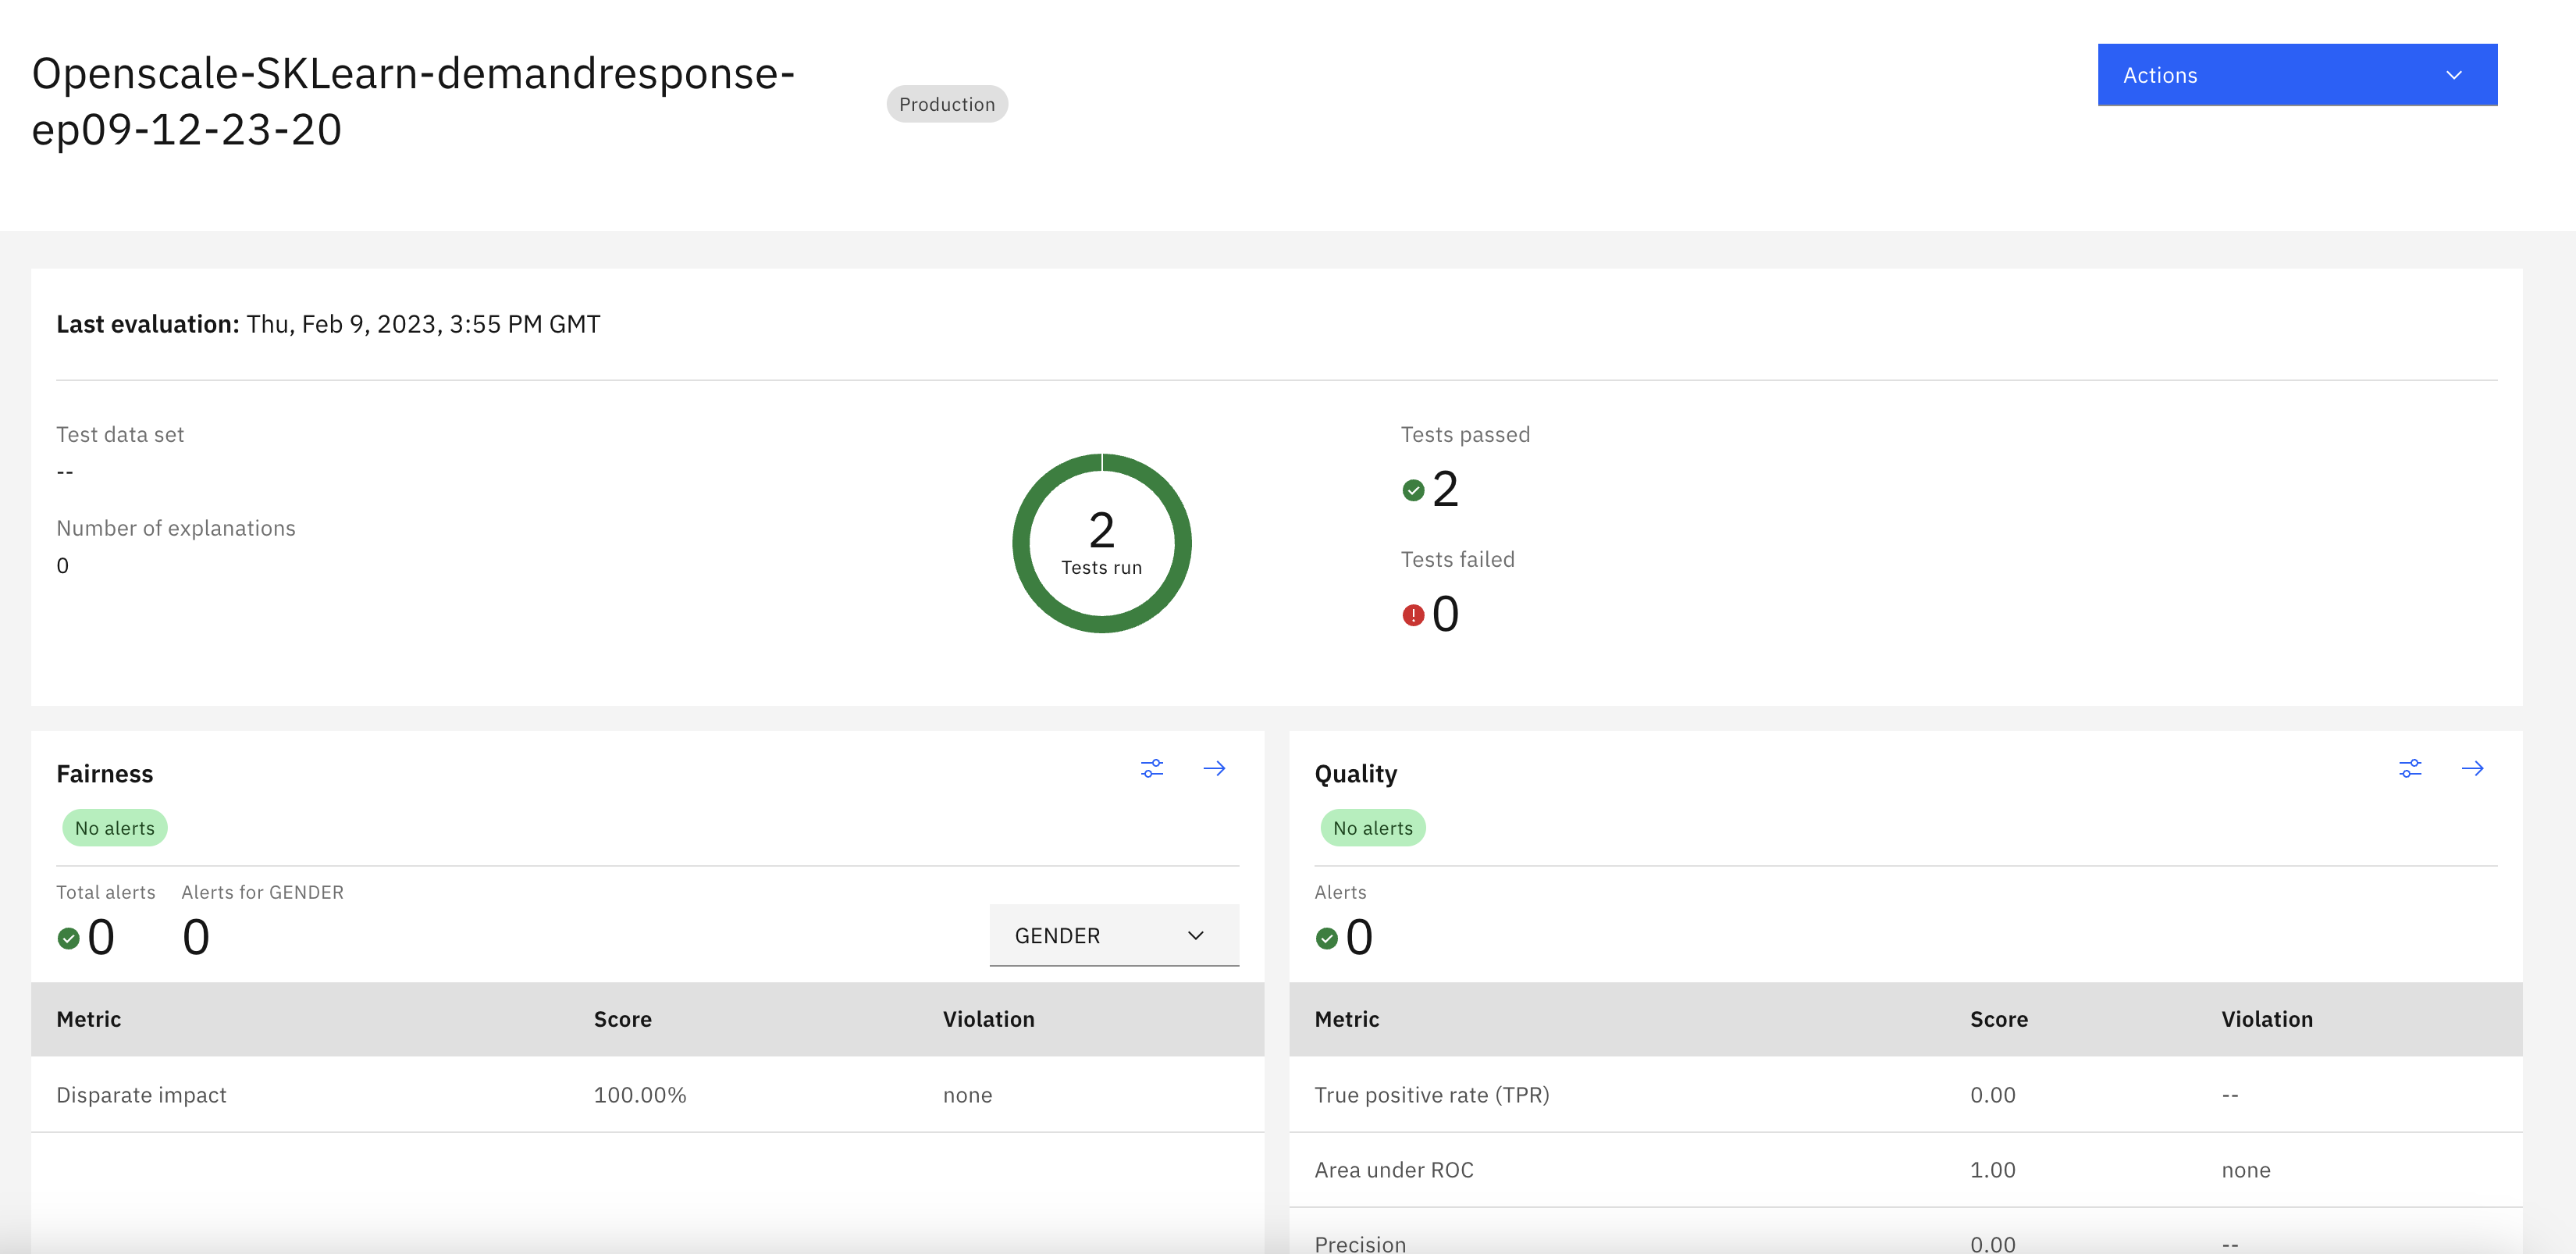